# Pain Classification Pipeline - Multi-class LSTM

Clean pipeline for pain classification using LSTM on time series data.

## 1. Setup

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
 )
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Create figures directory
Path('./figures').mkdir(exist_ok=True)

def to_categorical(y, num_classes):
    y = np.asarray(y, dtype=np.int64)
    return np.eye(num_classes, dtype=np.float32)[y]

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


PyTorch version: 2.9.0+cpu
NumPy version: 2.2.6
Pandas version: 2.3.3


## 2. Data Loading

In [125]:
# %%
# Load data files
train_df = pd.read_csv('pirate_pain_train.csv')
labels_df = pd.read_csv('pirate_pain_train_labels.csv')
test_df = pd.read_csv('pirate_pain_test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Merge labels with train data
train_df = train_df.merge(labels_df, on='sample_index', how='left')

# Sort by time within each sequence
train_df = train_df.sort_values(['sample_index', 'time']).reset_index(drop=True)
test_df = test_df.sort_values(['sample_index', 'time']).reset_index(drop=True)

print("Data loaded successfully")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")


Data loaded successfully
Train shape: (105760, 41)
Test shape: (211840, 40)
Sample submission shape: (1324, 2)


In [126]:
# %%
print("\n=== Label Distribution ===")

# label_col = colonna presente solo nel train (oltre a sample_index)
label_col = [
    col for col in train_df.columns
    if col not in test_df.columns and col != 'sample_index'
][0]

# una label per ogni sequenza
train_label_series = train_df.groupby('sample_index')[label_col].first()
print(f"Label column: {label_col}")
print(train_label_series.value_counts().sort_index())

# mapping fisso label -> id
label_to_id = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
expected_labels = set(label_to_id.keys())
observed_labels = set(train_label_series.unique())

if observed_labels != expected_labels:
    missing = expected_labels - observed_labels
    unexpected = observed_labels - expected_labels
    raise ValueError(f"Label mismatch. Missing: {missing}, Unexpected: {unexpected}")

# applico mapping al dataframe
train_df[label_col] = train_df[label_col].map(label_to_id)

# id -> label (per submission)
id_to_label = {v: k for k, v in label_to_id.items()}
num_classes = len(label_to_id)

# opzionale: salvo mapping su disco
mapping_path = Path("label_mapping.json")
with open(mapping_path, "w") as f:
    json.dump({"label_to_id": label_to_id, "id_to_label": id_to_label}, f, indent=2)
print(f"\nSaved label mapping to: {mapping_path}")

# Sequence length statistics
train_seq_lengths = train_df.groupby('sample_index').size()
test_seq_lengths = test_df.groupby('sample_index').size()

print("\n=== Training Sequence Lengths ===")
print(f"Min: {train_seq_lengths.min()}")
print(f"Median: {train_seq_lengths.median():.0f}")
print(f"Max: {train_seq_lengths.max()}")
print(f"Total sequences: {len(train_seq_lengths)}")

print("\n=== Test Sequence Lengths ===")
print(f"Min: {test_seq_lengths.min()}")
print(f"Median: {test_seq_lengths.median():.0f}")
print(f"Max: {test_seq_lengths.max()}")
print(f"Total sequences: {len(test_seq_lengths)}")



=== Label Distribution ===
Label column: label
label
high_pain     56
low_pain      94
no_pain      511
Name: count, dtype: int64

Saved label mapping to: label_mapping.json

=== Training Sequence Lengths ===
Min: 160
Median: 160
Max: 160
Total sequences: 661

=== Test Sequence Lengths ===
Min: 160
Median: 160
Max: 160
Total sequences: 1324


In [127]:
# %%
# Stratified train/validation split at sequence level
sample_labels = train_df.groupby('sample_index')[label_col].first()

train_indices, val_indices = train_test_split(
    sample_labels.index,
    test_size=0.2,
    random_state=SEED,
    stratify=sample_labels
)

train_indices = np.array(sorted(train_indices))
val_indices = np.array(sorted(val_indices))

print("\n=== Train/Validation Split ===")
print(f"Train sequences: {len(train_indices)}")
print(f"Validation sequences: {len(val_indices)}")
print(f"Class distribution (train):\n{sample_labels.loc[train_indices].value_counts().sort_index()}")
print(f"Class distribution (val):\n{sample_labels.loc[val_indices].value_counts().sort_index()}")



=== Train/Validation Split ===
Train sequences: 528
Validation sequences: 133
Class distribution (train):
label
0    408
1     75
2     45
Name: count, dtype: int64
Class distribution (val):
label
0    103
1     19
2     11
Name: count, dtype: int64


## 3. Feature Groups Definition

In [128]:
# %%
# Identify feature columns
exclude_cols = {'sample_index', 'time', label_col}
all_feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# JOINT features: joint_00 to joint_XX (continuous, time-varying)
joint_cols = [col for col in all_feature_cols if col.startswith('joint_')]

# SURVEY features: pain_survey_1 to pain_survey_4 (ordinal 0/1/2)
survey_cols = [col for col in all_feature_cols if col.startswith('pain_survey_')]

# BODY features: static subject features (incl. n_leg, n_hand, n_eye, ecc.)
body_cols = [col for col in all_feature_cols if col not in joint_cols + survey_cols]

# Separate body into categorical and continuous
body_cat_cols = [col for col in body_cols if train_df[col].dtype == 'object']
body_cont_cols = [col for col in body_cols if col not in body_cat_cols]

print("=== Feature Groups ===")
print(f"JOINT features ({len(joint_cols)}): {joint_cols[:3]} ... {joint_cols[-3:]}")
print(f"SURVEY features ({len(survey_cols)}): {survey_cols}")
print(f"BODY categorical ({len(body_cat_cols)}): {body_cat_cols}")
print(f"BODY continuous ({len(body_cont_cols)}): {body_cont_cols}")
print(f"\nTotal features: {len(all_feature_cols)}")


=== Feature Groups ===
JOINT features (31): ['joint_00', 'joint_01', 'joint_02'] ... ['joint_28', 'joint_29', 'joint_30']
SURVEY features (4): ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
BODY categorical (3): ['n_legs', 'n_hands', 'n_eyes']
BODY continuous (0): []

Total features: 38


## 4. Preprocessing

In [129]:
# %%
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def preprocess_data(
    df,
    joint_cols,
    survey_cols,
    body_cat_cols,
    body_cont_cols,
    scaler_joint=None,
    scaler_survey=None,
    body_cat_mappings=None,
    is_train=True,
):
    """
    Preprocess data:
    - sort by (sample_index, time)
    - interpolate JOINT features
    - fill BODY continuous
    - map BODY categorical (n_leg, n_hand, n_eye, ecc.) -> integer codes
    - scale JOINT + BODY continuous (StandardScaler)
    - scale SURVEY (MinMaxScaler)
    """
    df = df.copy()
    df = df.sort_values(["sample_index", "time"])

    # 1. Interpolate JOINT (per sequenza)
    if joint_cols:
        df[joint_cols] = (
            df.groupby("sample_index")[joint_cols]
              .apply(lambda g: g.interpolate(method="linear").ffill().bfill())
              .reset_index(level=0, drop=True)
        )

    # 2. BODY continuous: ffill/bfill per sequenza
    if body_cont_cols:
        df[body_cont_cols] = (
            df.groupby("sample_index")[body_cont_cols]
              .apply(lambda g: g.ffill().bfill())
              .reset_index(level=0, drop=True)
        )

    # 3. BODY categorical: costruisci / applica mapping per colonna
    if body_cat_cols:
        if is_train and body_cat_mappings is None:
            body_cat_mappings = {}
            for col in body_cat_cols:
                vals = (
                    df[col]
                    .dropna()
                    .astype(str)
                    .unique()
                )
                vals = sorted(vals)
                mapping = {v: i for i, v in enumerate(vals)}
                mapping["__unknown__"] = len(mapping)
                body_cat_mappings[col] = mapping
        elif body_cat_mappings is None:
            raise ValueError("body_cat_mappings must be provided for is_train=False")

        for col in body_cat_cols:
            mapping = body_cat_mappings[col]
            unknown_code = mapping["__unknown__"]

            df[col] = df[col].astype(str).apply(
                lambda v: mapping.get(v, unknown_code)
            )

        # fill eventuali NaN per sequenza con median
        for col in body_cat_cols:
            df[col] = (
                df.groupby("sample_index")[col]
                  .transform(lambda s: s.fillna(s.median()))
            )

    # 4. Scaling
    cont_cols_for_scaler = joint_cols + body_cont_cols

    if is_train:
        if cont_cols_for_scaler:
            scaler_joint = StandardScaler()
            df[cont_cols_for_scaler] = scaler_joint.fit_transform(df[cont_cols_for_scaler])

        if survey_cols:
            scaler_survey = MinMaxScaler(feature_range=(0, 1))
            df[survey_cols] = scaler_survey.fit_transform(df[survey_cols])
    else:
        if cont_cols_for_scaler and scaler_joint is not None:
            df[cont_cols_for_scaler] = scaler_joint.transform(df[cont_cols_for_scaler])

        if survey_cols and scaler_survey is not None:
            df[survey_cols] = scaler_survey.transform(df[survey_cols])

    return df, scaler_joint, scaler_survey, body_cat_mappings


# --- Applico preprocessing a train/val/test ---

# split per sample_index
train_df_train = train_df[train_df['sample_index'].isin(train_indices)].copy()
train_df_val   = train_df[train_df['sample_index'].isin(val_indices)].copy()

train_df_train, scaler_joint, scaler_survey, body_cat_mappings = preprocess_data(
    train_df_train,
    joint_cols, survey_cols,
    body_cat_cols, body_cont_cols,
    scaler_joint=None,
    scaler_survey=None,
    body_cat_mappings=None,
    is_train=True,
)

train_df_val, _, _, _ = preprocess_data(
    train_df_val,
    joint_cols, survey_cols,
    body_cat_cols, body_cont_cols,
    scaler_joint=scaler_joint,
    scaler_survey=scaler_survey,
    body_cat_mappings=body_cat_mappings,
    is_train=False,
)

test_df_processed, _, _, _ = preprocess_data(
    test_df,
    joint_cols, survey_cols,
    body_cat_cols, body_cont_cols,
    scaler_joint=scaler_joint,
    scaler_survey=scaler_survey,
    body_cat_mappings=body_cat_mappings,
    is_train=False,
)
test_df = test_df_processed

print("Preprocessing completed")
print(f"Training data shape: {train_df_train.shape}")
print(f"Validation data shape: {train_df_val.shape}")
print(f"Test data shape: {test_df.shape}")


Preprocessing completed
Training data shape: (84480, 41)
Validation data shape: (21280, 41)
Test data shape: (211840, 40)


In [130]:
# %%
train_df_train.head()


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,1.0,0.0,1.0,0.5,1,1,1,0.744965,...,-0.007520,-0.022874,-0.039364,-0.029233,-0.401007,-0.555541,-0.374708,-0.480330,0.0,0
1,0,1,1.0,1.0,1.0,1.0,1,1,1,0.945679,...,-0.007727,-0.021404,-0.070840,-0.030302,-0.470289,-0.721823,-0.605195,-0.678392,0.0,0
2,0,2,1.0,0.0,1.0,1.0,1,1,1,0.675740,...,-0.007810,-0.024732,-0.064324,-0.029596,-0.423339,-0.621984,-0.421089,-0.546492,0.0,0
3,0,3,1.0,1.0,1.0,1.0,1,1,1,-0.031994,...,-0.007748,-0.024440,-0.070818,-0.030302,-0.495138,-0.630113,-0.343530,-0.524813,0.0,0
4,0,4,1.0,1.0,1.0,1.0,1,1,1,0.722550,...,-0.007809,-0.024655,-0.070808,-0.028324,-0.600881,-0.690660,-0.267742,-0.515263,0.0,0


## 5. Sequence Length Uniformization

In [131]:
# %%
def create_sequences(df, label_col=None, T_target=None):
    """
    Convert dataframe to sequences of uniform length.
    - If shorter than T_target: edge padding (repeat last frame)
    - If longer than T_target: truncate from the end
    """
    feature_cols = joint_cols + survey_cols + body_cols

    # Calcola T_target dal train se non fornito
    if T_target is None:
        seq_lengths = df.groupby('sample_index').size()
        T_target = int(seq_lengths.max())
        print(f"T_target automatically set to: {T_target}")

    X_list = []
    y_list = []
    sample_indices = []

    for sample_idx in df['sample_index'].unique():
        seq_df = df[df['sample_index'] == sample_idx].sort_values('time')
        seq_features = seq_df[feature_cols].values
        seq_len = len(seq_features)

        if seq_len < T_target:
            pad_len = T_target - seq_len
            pad_block = np.repeat(seq_features[-1:, :], pad_len, axis=0)
            seq_padded = np.concatenate([seq_features, pad_block], axis=0)
        elif seq_len > T_target:
            seq_padded = seq_features[-T_target:, :]
        else:
            seq_padded = seq_features

        X_list.append(seq_padded)
        sample_indices.append(sample_idx)

        if label_col is not None:
            y_list.append(seq_df[label_col].iloc[0])

    X = np.array(X_list)
    if label_col is not None:
        y = np.array(y_list, dtype=np.int64)
        return X, y, T_target, sample_indices
    else:
        return X, None, T_target, sample_indices


# --- Creazione sequenze per train / val / test ---
X_train, y_train, T_target, train_sample_indices = create_sequences(
    train_df_train,
    label_col=label_col,
    T_target=None,
)

X_val, y_val, _, val_sample_indices = create_sequences(
    train_df_val,
    label_col=label_col,
    T_target=T_target,
)

X_test, _, _, test_sample_indices = create_sequences(
    test_df,
    label_col=None,
    T_target=T_target,
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}")


T_target automatically set to: 160
Training set: (528, 160, 38), (528,)
Validation set: (133, 160, 38), (133,)
Test set: (1324, 160, 38)
Training set: (528, 160, 38), (528,)
Validation set: (133, 160, 38), (133,)
Test set: (1324, 160, 38)


In [132]:
# %%
# class weights bilanciati su y_train (sequence-level)
cw = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=y_train,
)

cw_tuned = cw.copy()  # qui puoi eventualmente modificare a mano

class_weights = {int(i): float(w) for i, w in enumerate(cw_tuned)}
print("Class weights:", class_weights)


Class weights: {0: 0.43137254901960786, 1: 2.3466666666666667, 2: 3.911111111111111}


In [133]:
# --- conversione numpy -> torch ---
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).long()

X_val_t   = torch.from_numpy(X_val).float()
y_val_t   = torch.from_numpy(y_val).long()

X_test_t  = torch.from_numpy(X_test).float()

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)
test_ds  = TensorDataset(X_test_t)   # solo X

print("Train ds:", len(train_ds))
print("Val ds:", len(val_ds))
print("Test ds:", len(test_ds))

# --- funzione DataLoader in stile Timeseries Classification ---
def make_loader(ds, batch_size, shuffle, drop_last):
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,
    )

BATCH_SIZE = 64  # puoi cambiare

train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_loader   = make_loader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

Train ds: 528
Val ds: 133
Test ds: 1324


## 6. Model Architecture

In [134]:
# %%
import torch.nn as nn
import torch.nn.functional as F

class SpatialDropout1D(nn.Module):
    def __init__(self, p: float):
        super().__init__()
        self.p = float(p)

    def forward(self, inputs):
        if self.p <= 0.0 or not self.training:
            return inputs
        x = inputs.unsqueeze(2)              # (B,T,1,F)
        x = F.dropout2d(x, p=self.p, training=self.training)
        return x.squeeze(2)                  # (B,T,F)

class LSTMClassifier(nn.Module):
    """
    LSTM puro (1–3 layer) per classificazione di sequenze.
    """
    def __init__(
        self,
        input_dim: int,
        num_classes: int,
        hidden_size: int = 64,
        num_layers: int = 1,
        dropout: float = 0.0,
        spatial_do: float = 0.0,
        bidirectional: bool = False,   # puoi lasciarlo False
    ):
        super().__init__()
        self.bidirectional = bidirectional
        self.spatial_dropout = SpatialDropout1D(spatial_do) if spatial_do > 0 else None

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=(dropout if num_layers > 1 else 0.0),
            bidirectional=bidirectional,
        )

        out_dim = hidden_size * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(out_dim, num_classes)

    def forward(self, x):
        # x: (B, T, F)
        if self.spatial_dropout is not None:
            x = self.spatial_dropout(x)

        out, (h_n, c_n) = self.lstm(x)  # h_n: (num_layers * num_directions, B, H)

        if self.bidirectional:
            # concat ultimo layer forward e backward
            fw = h_n[-2]   # (B,H)
            bw = h_n[-1]   # (B,H)
            feat = torch.cat([fw, bw], dim=-1)  # (B, 2H)
        else:
            feat = h_n[-1]  # (B,H)

        feat = self.dropout(feat)
        logits = self.classifier(feat)  # (B, C)
        return logits

input_dim = X_train.shape[2]
print("Input dim:", input_dim, "Num classes:", num_classes)


Input dim: 38 Num classes: 3


## 7 Fun training

In [135]:
# %%
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import numpy as np
import copy
from typing import Dict, Any

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    all_targets = []
    all_preds = []
    running_loss = 0.0

    for xb, yb in loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

        preds = logits.argmax(dim=1).detach().cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.detach().cpu().numpy())

    all_targets = np.concatenate(all_targets)
    all_preds   = np.concatenate(all_preds)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = accuracy_score(all_targets, all_preds)
    epoch_f1   = f1_score(all_targets, all_preds, average="macro")

    return epoch_loss, epoch_acc, epoch_f1

def validate_one_epoch(model, loader, criterion):
    model.eval()
    all_targets = []
    all_preds = []
    running_loss = 0.0

    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb)
            loss = criterion(logits, yb)

            running_loss += loss.item() * xb.size(0)

            preds = logits.argmax(dim=1).detach().cpu().numpy()
            all_preds.append(preds)
            all_targets.append(yb.detach().cpu().numpy())

    all_targets = np.concatenate(all_targets)
    all_preds   = np.concatenate(all_preds)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = accuracy_score(all_targets, all_preds)
    epoch_f1   = f1_score(all_targets, all_preds, average="macro")

    return epoch_loss, epoch_acc, epoch_f1, all_targets, all_preds

def fit_lstm_model(
    config: Dict[str, Any],
    train_loader,
    val_loader,
    input_dim: int,
    num_classes: int,
    class_weights: Dict[int, float] = None,
    max_epochs: int = 60,
    patience: int = 10,
    verbose: int = 1,
):
    """
    Allena un LSTM con early stopping su F1 macro.
    """
    # --- modello ---
    model = LSTMClassifier(
        input_dim=input_dim,
        num_classes=num_classes,
        hidden_size=config["hidden_size"],
        num_layers=config["num_layers"],
        dropout=config["dropout"],
        spatial_do=config.get("spatial_do", 0.0),
        bidirectional=config.get("bidirectional", False),
    )

    # --- loss (con o senza pesi di classe) ---
    use_class_weights = config.get("use_class_weights", False)
    if use_class_weights and class_weights is not None:
        w = torch.tensor(
            [class_weights[i] for i in range(num_classes)],
            dtype=torch.float32,
        )
        criterion = nn.CrossEntropyLoss(weight=w)
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config["lr"],
        weight_decay=config.get("weight_decay", 0.0),
    )

    history = {
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
    }

    best_f1 = -np.inf
    best_state = None
    best_epoch = 0
    no_improve = 0

    for epoch in range(1, max_epochs + 1):
        train_loss, train_acc, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer
        )
        val_loss, val_acc, val_f1, y_true, y_pred = validate_one_epoch(
            model, val_loader, criterion
        )

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        if verbose:
            print(
                f"Epoch {epoch:03d} | "
                f"Train F1: {train_f1:.4f}  Val F1: {val_f1:.4f}  "
                f"(Val Loss: {val_loss:.4f})"
            )

        if val_f1 > best_f1 + 1e-4:
            best_f1 = val_f1
            best_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                if verbose:
                    print(f"Early stopping a epoch {epoch} (best epoch {best_epoch})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history, best_f1, best_epoch


## 8 Grid

In [136]:
# %%
from itertools import product

# griglia: qui scegli layer e se usare i pesi di classe
param_grid = {
    "hidden_size":      [128],
    "num_layers":       [2],      # 1 / 2 / 3 layer
    "dropout":          [0.2, 0.1],
    "spatial_do":       [0.0],
    "lr":               [5e-4],
    "weight_decay":     [0.0],
    "use_class_weights":[False],  # True/False per usare i pesi
}

MAX_EPOCHS = 60
PATIENCE   = 10

def grid_search_lstm(
    param_grid,
    train_loader,
    val_loader,
    input_dim,
    num_classes,
    class_weights=None,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
):
    keys = list(param_grid.keys())
    all_values = [param_grid[k] for k in keys]
    configs = list(product(*all_values))

    print(f"Numero totale di configurazioni: {len(configs)}")

    results = []
    best_global_f1 = -np.inf
    best_global_config = None
    best_global_model_state = None
    best_global_history = None

    for i, values in enumerate(configs, start=1):
        config = dict(zip(keys, values))
        print("\n" + "="*70)
        print(f"Config {i}/{len(configs)}:")
        for k, v in config.items():
            print(f"  {k}: {v}")

        model, history, best_f1, best_epoch = fit_lstm_model(
            config=config,
            train_loader=train_loader,
            val_loader=val_loader,
            input_dim=input_dim,
            num_classes=num_classes,
            class_weights=class_weights,
            max_epochs=max_epochs,
            patience=patience,
            verbose=1,
        )

        result = {
            "config": config,
            "best_val_f1": float(best_f1),
            "best_epoch": int(best_epoch),
            "history": history,
        }
        results.append(result)

        if best_f1 > best_global_f1:
            best_global_f1 = best_f1
            best_global_config = config
            best_global_model_state = copy.deepcopy(model.state_dict())
            best_global_history = history

    # ricrea il modello migliore con il suo stato
    best_model = LSTMClassifier(
        input_dim=input_dim,
        num_classes=num_classes,
        hidden_size=best_global_config["hidden_size"],
        num_layers=best_global_config["num_layers"],
        dropout=best_global_config["dropout"],
        spatial_do=best_global_config.get("spatial_do", 0.0),
        bidirectional=best_global_config.get("bidirectional", False),
    )
    best_model.load_state_dict(best_global_model_state)

    summary = {
        "best_config": best_global_config,
        "best_val_f1": float(best_global_f1),
        "best_history": best_global_history,
        "all_results": results,
    }

    return best_model, summary

best_model, grid_summary = grid_search_lstm(
    param_grid=param_grid,
    train_loader=train_loader,
    val_loader=val_loader,
    input_dim=input_dim,
    num_classes=num_classes,
    class_weights=class_weights,
)

print("\n=== MIGLIORE CONFIGURAZIONE ===")
print(grid_summary["best_config"])
print("Best Val F1 macro:", grid_summary["best_val_f1"])


Numero totale di configurazioni: 2

Config 1/2:
  hidden_size: 128
  num_layers: 2
  dropout: 0.2
  spatial_do: 0.0
  lr: 0.0005
  weight_decay: 0.0
  use_class_weights: False
Epoch 001 | Train F1: 0.2918  Val F1: 0.2910  (Val Loss: 0.9301)
Epoch 001 | Train F1: 0.2918  Val F1: 0.2910  (Val Loss: 0.9301)
Epoch 002 | Train F1: 0.3000  Val F1: 0.2910  (Val Loss: 0.6698)
Epoch 002 | Train F1: 0.3000  Val F1: 0.2910  (Val Loss: 0.6698)
Epoch 003 | Train F1: 0.3051  Val F1: 0.3569  (Val Loss: 0.6431)
Epoch 003 | Train F1: 0.3051  Val F1: 0.3569  (Val Loss: 0.6431)
Epoch 004 | Train F1: 0.3664  Val F1: 0.3856  (Val Loss: 0.6106)
Epoch 004 | Train F1: 0.3664  Val F1: 0.3856  (Val Loss: 0.6106)
Epoch 005 | Train F1: 0.4188  Val F1: 0.5171  (Val Loss: 0.5975)
Epoch 005 | Train F1: 0.4188  Val F1: 0.5171  (Val Loss: 0.5975)
Epoch 006 | Train F1: 0.4788  Val F1: 0.4887  (Val Loss: 0.5807)
Epoch 006 | Train F1: 0.4788  Val F1: 0.4887  (Val Loss: 0.5807)
Epoch 007 | Train F1: 0.4372  Val F1: 0.5033

## 8. Final Training with Best Model

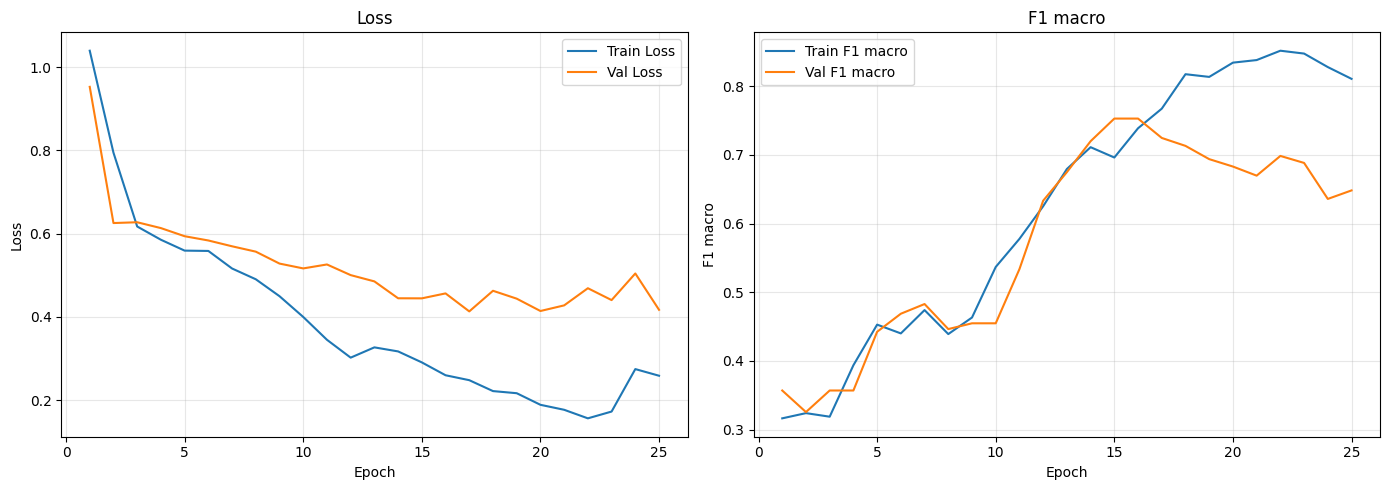

In [137]:
# %%
best_history = grid_summary["best_history"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(best_history["train_loss"]) + 1)

# Loss
axes[0].plot(epochs_range, best_history["train_loss"], label="Train Loss")
axes[0].plot(epochs_range, best_history["val_loss"],   label="Val Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss")
axes[0].legend()
axes[0].grid(alpha=0.3)

# F1 macro
axes[1].plot(epochs_range, best_history["train_f1"], label="Train F1 macro")
axes[1].plot(epochs_range, best_history["val_f1"],   label="Val F1 macro")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("F1 macro")
axes[1].set_title("F1 macro")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 9. Evaluation and Visualization

Classification report (val):
              precision    recall  f1-score   support

     no_pain       0.92      0.96      0.94       103
    low_pain       0.80      0.84      0.82        19
   high_pain       0.80      0.36      0.50        11

    accuracy                           0.89       133
   macro avg       0.84      0.72      0.75       133
weighted avg       0.89      0.89      0.89       133



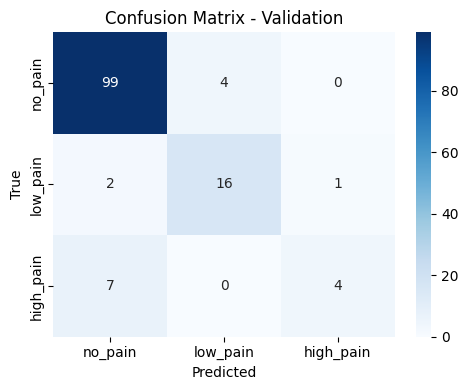

In [138]:
# %%
# Confusion matrix sul validation set per il best_model
best_model.eval()
all_targets = []
all_preds = []

with torch.no_grad():
    for xb, yb in val_loader:
        logits = best_model(xb)
        preds = logits.argmax(dim=1)

        all_targets.append(yb.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_targets = np.concatenate(all_targets)
all_preds   = np.concatenate(all_preds)

cm = confusion_matrix(all_targets, all_preds)
print("Classification report (val):")
print(classification_report(all_targets, all_preds,
                            target_names=[id_to_label[i] for i in range(num_classes)]))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=[id_to_label[i] for i in range(num_classes)],
            yticklabels=[id_to_label[i] for i in range(num_classes)],
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Validation")
plt.tight_layout()
plt.show()


In [139]:
# %%
def predict_loader_proba(model, loader):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for (xb,) in loader:   # test_ds ha solo X
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)
            all_probs.append(probs.cpu().numpy())
    return np.concatenate(all_probs, axis=0)

test_proba = predict_loader_proba(best_model, test_loader)
test_pred  = test_proba.argmax(axis=1)

print("Test proba shape:", test_proba.shape)
print("Test pred shape:",  test_pred.shape)
print("Num test sample_indices:", len(test_sample_indices))
print("Sample submission rows:", len(sample_submission))


Test proba shape: (1324, 3)
Test pred shape: (1324,)
Num test sample_indices: 1324
Sample submission rows: 1324


## 10. Test Predictions and Submission

In [140]:
# %%
# Costruzione submission in formato Kaggle, usando sample_submission come template
submission_df = sample_submission.copy()

# prima colonna = id, il resto colonne (in questo caso una sola colonna 'label')
id_col = submission_df.columns[0]
label_cols = submission_df.columns[1:]

# mappa sample_index -> predizione
pred_map = dict(zip(test_sample_indices, test_pred))

for idx, row in submission_df.iterrows():
    sample_id = row[id_col]
    if sample_id in pred_map:
        pred_class = int(pred_map[sample_id])
        pred_label = id_to_label[pred_class]
        submission_df.loc[idx, label_cols] = pred_label

submission_df.to_csv("submission.csv", index=False)
print("Salvato submission.csv")
print(submission_df.head())


Salvato submission.csv
   sample_index    label
0             0  no_pain
1             1  no_pain
2             2  no_pain
3             3  no_pain
4             4  no_pain
